# Serial Position Cell Analysis

Analyze TH data for serial positon cells. 

Cells of interest:
- 74 looks to be a serial position cell (not sure which session...)

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from scipy.stats import sem
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from pynwb import NWBHDF5IO

from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue
from spiketools.plts.space import plot_positions
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.plts.data import plot_bar
from spiketools.utils import restrict_range
from spiketools.utils.data import get_value_by_time, get_value_by_time_range

In [3]:
import seaborn as sns
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions
from target import compute_serial_position_fr

# Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH/')

In [6]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [7]:
# Shuffle Settings
# shuffle_approach = 'BINCIRC'

shuffle_approach = 'CIRCULAR'
n_surrogates = 100

In [8]:
# Set example unit to analyze
uind = 74

# Load Data

In [9]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [10]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

#### Get Trial Data

In [11]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [12]:
# Extract behavioural markers of interest
nav_starts = nwbfile.trials['navigation_start'].data[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

#### Get Unit Data

In [13]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [14]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

#### Get Position Data

In [15]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T

In [16]:
# Get the chest positions & trial indices
chest_xs, chest_ys = nwbfile.acquisition['chest_positions']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

# ANOVA Test

Use fr ~ C(segment), real data

## Single Trial

In [17]:
# Get trial information
t_ind = 10
#t_st = nwbfile.trials['start_time'][t_ind]
t_st = nwbfile.trials['navigation_start'][t_ind]
ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
t_en = ch_openings[-1]

In [18]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [19]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [20]:
# Restrict spikes to the selected trial
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)
spike_positions = np.array([t_spike_xs, t_spike_ys])

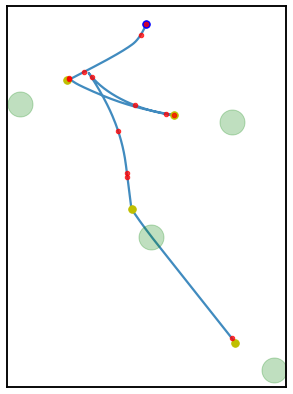

In [21]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
plot_positions(t_pos, alpha=0.85, figsize=(5, 7))
ax = plt.gca()
ax.plot(*t_pos[:, 0], 'b.', ms=15)
[ax.plot(*cht, 'y.', ms=15) for cht in ch_times];
ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=50, alpha=0.25)
ax.plot(t_spike_xs, t_spike_ys, '.r', alpha=0.75,)

In [22]:
# Get the length of time between segments (chest openings)
seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))

In [23]:
# Count firing in each segment, and compute firing rate
count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
count.update(np.digitize(t_spikes, ch_openings))
frs = np.array(list(count.values())) / seg_times

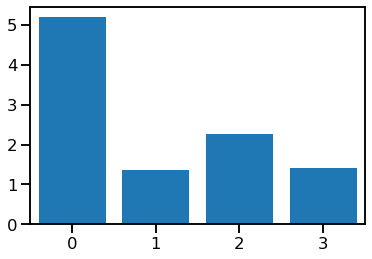

In [24]:
# Plot firing rate per segment (single trial)
plot_bar(frs, count.keys())

In [25]:
# Compute firing rates per segment for each trial
all_frs = compute_serial_position_fr(spikes, nav_starts, chest_openings, chest_trials, ptimes, positions)

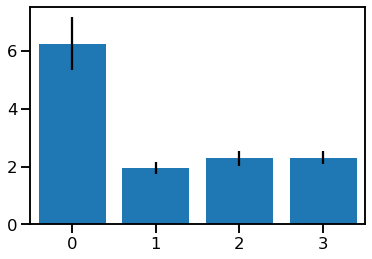

In [26]:
# Plot firing rates per segment across all trials
plot_bar(all_frs.mean(0), count.keys(), yerr=sem(all_frs, 0))

In [27]:
# create segment label
all_frs_1d = all_frs.flatten()
segment_label = np.array(range(0, 4))
segment_label = np.tile(segment_label,n_trials)

merged_array = np.transpose(np.vstack([segment_label,all_frs_1d]))
df = pd.DataFrame(merged_array,columns=['segment', 'fr'])

In [28]:
df.head(10)

,segment,fr
0,0.0,5.020511
1,1.0,3.369822
2,2.0,3.412338
3,3.0,4.148399
4,0.0,12.629948
5,1.0,1.626008
6,2.0,3.435894
7,3.0,4.959912
8,0.0,20.379373
9,1.0,4.685548


In [29]:
# build the ANOVA model
model = smf.ols('fr ~ C(segment)', data=df).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                sum_sq    df          F        PR(>F)
C(segment)  301.660849   3.0  16.750739  9.186460e-09
Residual    552.270129  92.0        NaN           NaN


In [30]:
# get the F-value from ANOVA model
f_val = aov_table['F']['C(segment)']
print(f_val)

16.750738855323224


In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fr   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     16.75
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           9.19e-09
Time:                        11:32:34   Log-Likelihood:                -220.20
No. Observations:                  96   AIC:                             448.4
Df Residuals:                      92   BIC:                             458.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.2583      0.500     12.514      0.000       5.265       7.252
C(segment)[T.1.0]    -4.3184      0.707     -6.106      0.000      -5.723      -2.914
C(segment)[T.2.0]    -3.9707      0.707     -5.614      0.000      -5.375      -2.566
C(segment)[T.3.0]    -3.9503      0.707     -5.585      0.000      -5.355      -2.546
==============================================================================
Omnibus:                       67.053   Durbin-Watson:                   1.408
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.319
Skew:                           1.998   Prob(JB):                    4.39e-131
Kurtosis:                      14.580   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## All trials

In [32]:
# Get the firing rate per bin, per trial
all_frs = np.zeros([n_trials, 4])
for ind in range(n_trials):
    
    # Get trial information
    t_st = nwbfile.trials['navigation_start'][ind]
    ch_openings = nwbfile.trials['chest_opening_time'][ind]
    t_en = ch_openings[-1]
    t_mask = chest_trials == ind

    t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
    ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

    t_spikes = restrict_range(spikes, t_st, t_en)
    t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

    # Get the length of time between segments (chest openings)
    seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
    # Count firing in each segment, and compute firing rate
    count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
    count.update(np.digitize(t_spikes, ch_openings))
    frs = np.array(list(count.values())) / seg_times

    # Compute firing rates per segment for each trial
    all_frs = compute_serial_position_fr(spikes, nav_starts, chest_openings, 
                                         chest_trials, ptimes, positions)

# create segment label
all_frs_1d = all_frs.flatten()
segment_label = np.array(range(0, 4))
segment_label = np.tile(segment_label,n_trials)

merged_array = np.transpose(np.vstack([segment_label,all_frs_1d]))
df = pd.DataFrame(merged_array,columns=['segment', 'fr'])

In [33]:
# build the ANOVA model
model = smf.ols('fr ~ C(segment)', data=df).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                sum_sq    df          F        PR(>F)
C(segment)  301.660849   3.0  16.750739  9.186460e-09
Residual    552.270129  92.0        NaN           NaN


In [34]:
# get the F-value from ANOVA model
f_val_surrs = aov_table['F']['C(segment)']

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fr   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     16.75
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           9.19e-09
Time:                        11:32:34   Log-Likelihood:                -220.20
No. Observations:                  96   AIC:                             448.4
Df Residuals:                      92   BIC:                             458.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.2583      0.500     12.514      0.000       5.265       7.252
C(segment)[T.1.0]    -4.3184      0.707     -6.106      0.000      -5.723      -2.914
C(segment)[T.2.0]    -3.9707      0.707     -5.614      0.000      -5.375      -2.566
C(segment)[T.3.0]    -3.9503      0.707     -5.585      0.000      -5.355      -2.546
==============================================================================
Omnibus:                       67.053   Durbin-Watson:                   1.408
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.319
Skew:                           1.998   Prob(JB):                    4.39e-131
Kurtosis:                      14.580   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# ANOVA Surrogate

Use fr ~ C(segment), 100 surrogates

In [36]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, shuffle_min=20000) #regular circular shuffle
surrogates = []

for i, j in enumerate (times_shuffle):
    all_frs = np.zeros([n_trials, 4])
    
    for ind in range(n_trials):
        
        # Get trial information
        t_st = nav_starts[ind]
        ch_openings = chest_openings[ind]
        t_en = ch_openings[-1]

        t_mask = chest_trials == ind

        t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
        ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

        t_spikes = restrict_range(times_shuffle[i], t_st, t_en)
        t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)
        
        # Get the length of time between segments (chest openings)
        seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
        # Count firing in each segment, and compute firing rate
        count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
        count.update(np.digitize(t_spikes, ch_openings))
        frs = np.array(list(count.values())) / seg_times

        # Compute firing rates per segment for each trial
        all_frs = compute_serial_position_fr(times_shuffle[i], nav_starts, chest_openings, 
                                             chest_trials, ptimes, positions)

    # create segment label
    all_frs_1d = all_frs.flatten()
    segment_label = np.array(range(0, 4))
    segment_label = np.tile(segment_label,n_trials)

    merged_array = np.transpose(np.vstack([segment_label,all_frs_1d]))
    df = pd.DataFrame(merged_array,columns=['segment', 'fr'])

    # build the ANOVA model
    model = smf.ols('fr ~ C(segment)', data=df).fit()
    aov_table = anova_lm(model, typ=2)

    # get the F-value from ANOVA model
    f_val_surrs = aov_table['F']['C(segment)']
    
    surrogates.append(f_val_surrs)

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fr   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     18.93
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           1.21e-09
Time:                        11:32:42   Log-Likelihood:                -201.35
No. Observations:                  96   AIC:                             410.7
Df Residuals:                      92   BIC:                             421.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.7332      0.411     13.951      0.000       4.917       6.549
C(segment)[T.1.0]    -3.3023      0.581     -5.682      0.000      -4.457      -2.148
C(segment)[T.2.0]    -3.5522      0.581     -6.112      0.000      -4.706      -2.398
C(segment)[T.3.0]    -3.8032      0.581     -6.544      0.000      -4.958      -2.649
==============================================================================
Omnibus:                       13.520   Durbin-Watson:                   1.365
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.388
Skew:                           0.535   Prob(JB):                     5.06e-06
Kurtosis:                       5.225   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

p-value: 0.11
z-score: 1.00


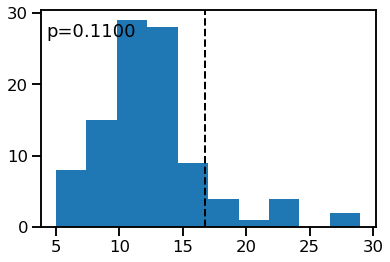

In [38]:
# Compute the empirical p-value based on surrogates
surr_p_val = compute_empirical_pvalue(f_val, surrogates)

# Compute z-score of the real F-value compared to surrogates
z_score = zscore_to_surrogates(f_val, surrogates)

# Print out the compute p-value and z-scored information
print('p-value: {:4.2f}'.format(surr_p_val))
print('z-score: {:4.2f}'.format(z_score))

# Plot the distribution of surrogates, comparing to real F-value
plot_surrogates(surrogates, f_val, surr_p_val)

# All Cells

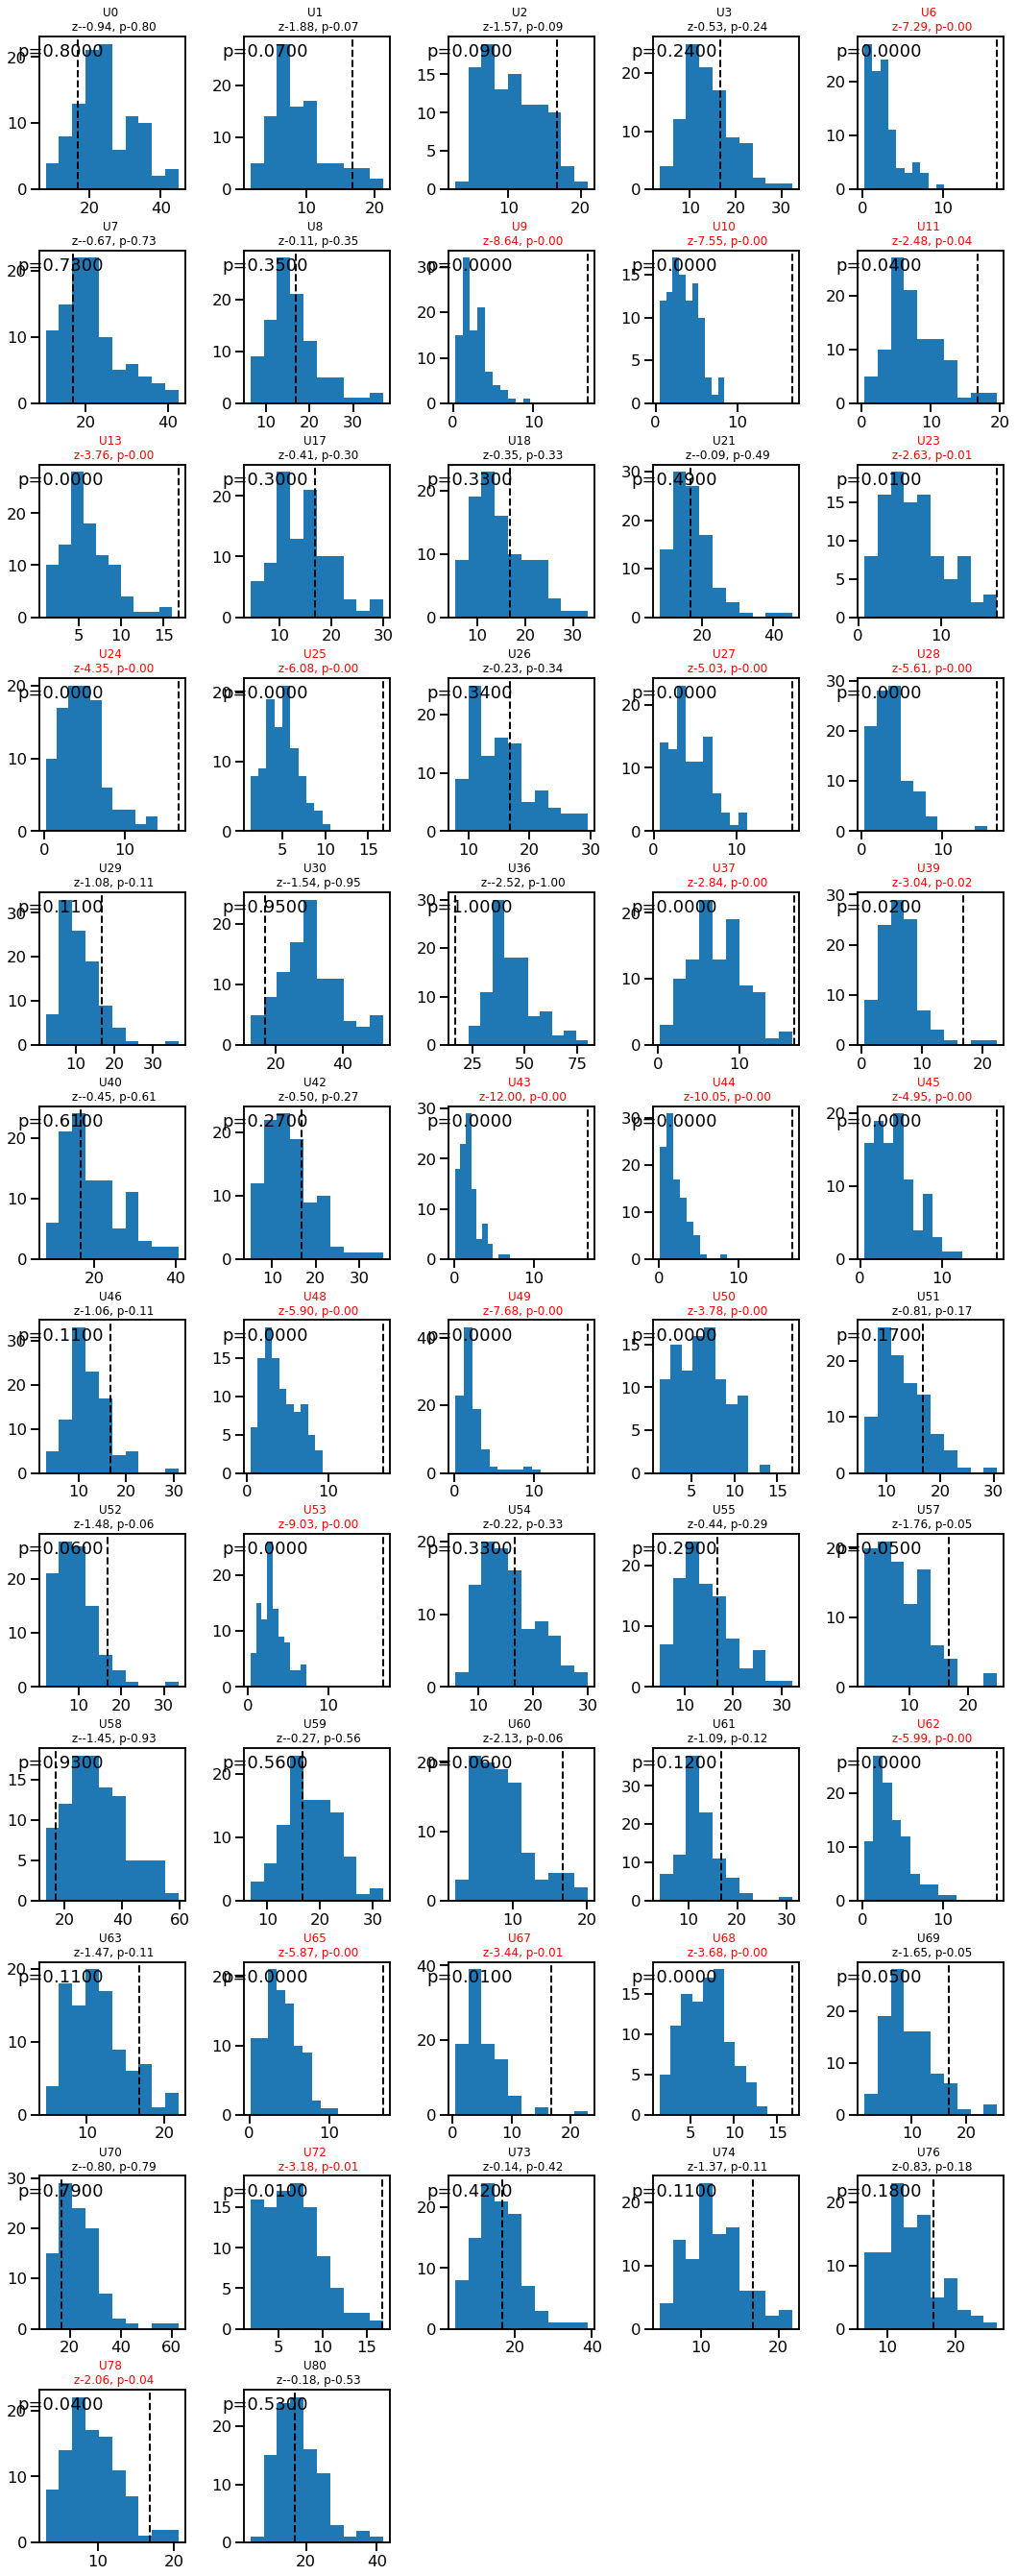

In [39]:
# Plot the firing rate per segment across trials for all units 
for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4, wspace=0.4)):

    spikes = nwbfile.units.get_unit_spike_times(ii)
    # Create shuffled time series for comparison
    times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, shuffle_min=20000) #regular circular shuffle
    surrogates = []

    for i, j in enumerate (times_shuffle):
        all_frs = np.zeros([n_trials, 4])

        for ind in range(n_trials):

            # Get trial information
            t_st = nav_starts[t_ind]
            ch_openings = chest_openings[t_ind]
            t_en = ch_openings[-1]

            t_mask = chest_trials == t_ind

            t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
            ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

            t_spikes = restrict_range(times_shuffle[i], t_st, t_en)
            t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

            # Get the length of time between segments (chest openings)
            seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
            # Count firing in each segment, and compute firing rate
            count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
            count.update(np.digitize(t_spikes, ch_openings))
            frs = np.array(list(count.values())) / seg_times

            # Compute firing rates per segment for each trial
            all_frs = compute_serial_position_fr(times_shuffle[i], nav_starts, chest_openings, 
                                                 chest_trials, ptimes, positions)

        # create segment label
        all_frs_1d = all_frs.flatten()
        segment_label = np.array(range(0, 4))
        segment_label = np.tile(segment_label,n_trials)

        merged_array = np.transpose(np.vstack([segment_label,all_frs_1d]))
        df = pd.DataFrame(merged_array,columns=['segment', 'fr'])

        # build the ANOVA model
        model = smf.ols('fr ~ C(segment)', data=df).fit()
        aov_table = anova_lm(model, typ=2)

        # get the F-value from ANOVA model
        f_val_surrs = aov_table['F']['C(segment)']

        surrogates.append(f_val_surrs)
            
    # Compute the empirical p-value based on surrogates
    surr_p_val = compute_empirical_pvalue(f_val, surrogates)

    # Compute z-score of the real F-value compared to surrogates
    z_score = zscore_to_surrogates(f_val, surrogates)

    # Plot the distribution of surrogates, comparing to real F-value
    plot_surrogates(surrogates, f_val, surr_p_val, ax=ax)
    
    color = 'red' if surr_p_val < 0.05 else 'black'
    title = 'U{} \n z-{:1.2f}, p-{:1.2f}'.format(ii, z_score, surr_p_val)
    ax.set_title(title, fontdict={'fontsize' : 12}, color=color)
        
#     # Plot firing rates per segment across all trials, and indicate significance
#     plot_bar(all_frs.mean(0), count.keys(), yerr=sem(all_frs, 0), ax=ax)
#     title = 'U{}'.format(ii)
#     ax.set_title(title, fontdict={'fontsize' : 12})
#     for ind, p_val in enumerate(surr_p_vals):
#         if p_val < 0.05:
#             ax.text(ind, ax.get_ylim()[1]-0.15*ax.get_ylim()[1],
#                     '*', c='red', fontdict={'fontsize' : 25}, ha='center')